In [10]:
# === 1. Necessary Imports ====================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow.keras.backend as K
df = pd.read_csv("ReadySoilDataset_Final.csv")
df = df[df['Region'].isin([2,4,5,7])].reset_index(drop=True)
df.head(10)

,Region,Year,Month,SoilTemperature-10,SoilTemperature-30,SoilTemperature-50,Rainfall,Temperature,Min Temperature,Max Temperature,Humidity,Sunshine,Wind Speed,Surface Pressure,Solar Radiation
0,2,2001,1,17.40,18.81,19.43,0.0,18.38,13.04,25.44,62.68,7.94,2.17,101268.29,199.25
1,2,2001,2,19.88,19.98,20.36,1.0,22.61,16.90,28.56,61.71,7.19,1.98,101039.08,210.73
2,2,2001,3,24.08,23.32,23.17,33.0,26.62,20.73,31.84,55.48,8.75,2.10,100882.56,251.75
3,2,2001,4,27.62,27.02,26.77,46.0,29.06,24.71,32.06,65.63,8.55,2.70,100655.40,257.46
4,2,2001,5,28.54,28.29,28.21,402.0,27.69,24.18,32.09,77.39,6.10,2.37,100234.63,172.32
5,2,2001,6,30.11,29.82,29.64,386.0,28.03,25.55,31.75,83.17,3.51,3.64,99934.18,140.45
6,2,2001,7,30.74,30.53,30.64,202.0,28.83,25.92,31.60,80.26,4.55,3.87,99991.05,169.40
7,2,2001,8,30.99,30.99,30.86,205.0,29.46,25.23,31.50,82.19,5.15,3.01,100129.68,181.66
8,2,2001,9,29.83,29.89,29.95,209.0,28.71,24.34,32.42,82.53,4.65,2.14,100499.17,170.22
9,2,2001,10,28.00,28.29,28.50,177.0,27.63,22.83,31.44,80.45,5.60,1.59,100864.38,167.89


In [27]:

# === 2. Feature / target selection ===========================================
features = df[['Month', 'Temperature', 'Min Temperature',
               'Max Temperature', 
               'Rainfall', 'Surface Pressure']]
target = df['SoilTemperature-50']

# === 3. Scaling ==============================================================

# Feature scaling with StandardScaler
feat_scaler = StandardScaler()
X_scaled = feat_scaler.fit_transform(features)

# Target scaling with MinMaxScaler
tgt_scaler = MinMaxScaler()
y_scaled = tgt_scaler.fit_transform(target.values.reshape(-1, 1))

# === 4. Sliding-window sequencing ============================================
def create_sliding_window(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

WINDOW = 12  # Define the window size for time-series sequences
X_seq, y_seq = create_sliding_window(X_scaled, y_scaled, WINDOW)

# === 5. Train / val / test split =============================================
X_train, X_tmp, y_train, y_tmp = train_test_split(X_seq, y_seq,
                                                  test_size=0.2,
                                                  random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp,
                                                test_size=0.5,
                                                random_state=2)


model = Sequential([
    # Conv1D Layer for feature extraction
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    # LSTM Layers
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    # Fully connected layers
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])




early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
lr_sched = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# === 6. Train the models =====================================================
# Train CNN-LSTM
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint, lr_sched],
    verbose=1
)

# === 10. Evaluation ===========================================================
results = model.evaluate(X_test, y_test, verbose=0)
loss = results[0]
mae = results[1]
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE:       {mae:.4f}")


# === 11. Prediction & inverse-scaling ========================================
y_pred_scaled = model.predict(X_test)
y_pred        = tgt_scaler.inverse_transform(y_pred_scaled)
y_true        = tgt_scaler.inverse_transform(y_test)

comparison = pd.DataFrame({
    'Predicted': y_pred.flatten(),
    'Actual':    y_true.flatten()
})
print(comparison.head(14))


Epoch 1/100
27/27 [==============================] - 6s 51ms/step - loss: 0.1292 - mae: 0.2927 - val_loss: 0.0508 - val_mae: 0.2025 - lr: 0.0010
Epoch 2/100
 6/27 [=====>........................] - ETA: 0s - loss: 0.0568 - mae: 0.2023

C:\Users\HP Laptop 15\tfenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 17ms/step - loss: 0.0422 - mae: 0.1686 - val_loss: 0.0175 - val_mae: 0.1019 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0233 - mae: 0.1191 - val_loss: 0.0189 - val_mae: 0.1149 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0204 - mae: 0.1102 - val_loss: 0.0094 - val_mae: 0.0712 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 0s 16ms/step - loss: 0.0171 - mae: 0.1024 - val_loss: 0.0091 - val_mae: 0.0705 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0163 - mae: 0.1004 - val_loss: 0.0086 - val_mae: 0.0678 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0142 - mae: 0.0890 - val_loss: 0.0123 - val_mae: 0.0904 - lr: 0.0010
Epoch 8/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0150 - mae: 0.0931 - val_loss: 0.0163 - val_mae: 0.1094 - lr: 0.00

In [ ]:
Test Loss (MSE): 0.0060
Test MAE:       0.0607

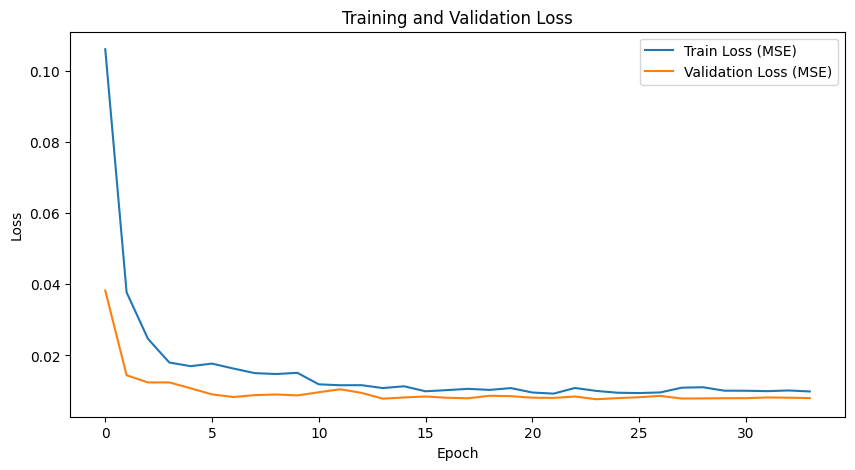

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

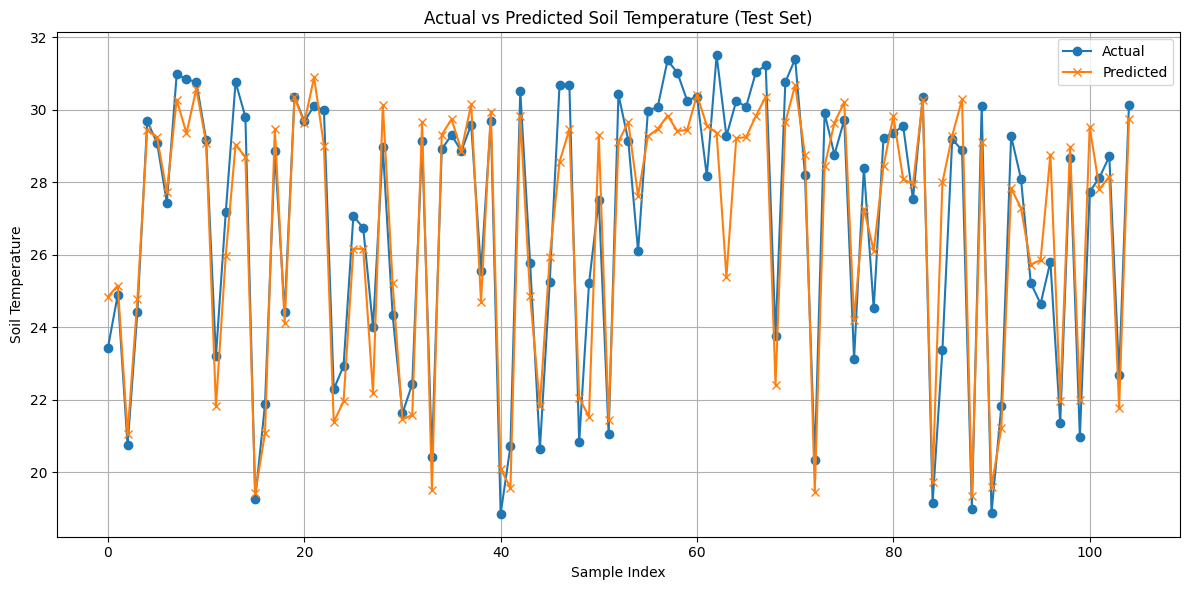

In [20]:


plt.figure(figsize=(12, 6))
plt.plot(comparison['Actual'].values, label='Actual', marker='o')
plt.plot(comparison['Predicted'].values, label='Predicted', marker='x')
plt.title('Actual vs Predicted Soil Temperature (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Soil Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


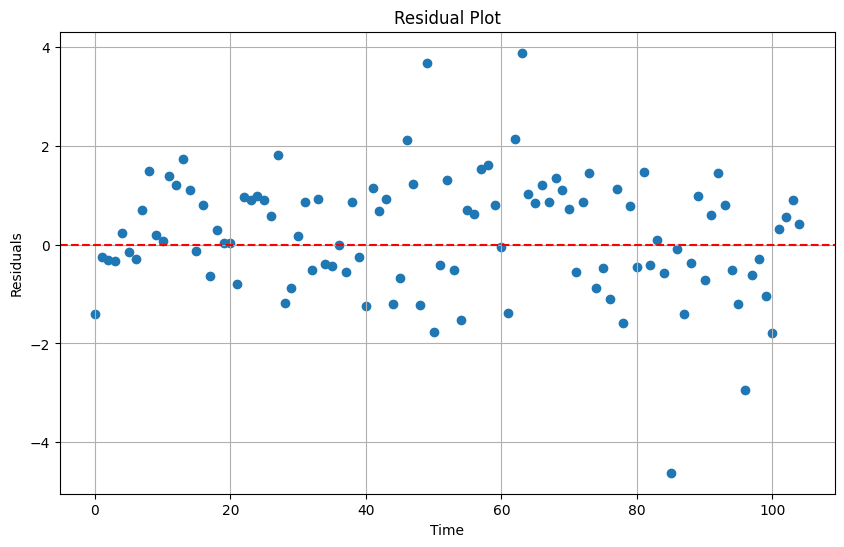

In [22]:
residuals = y_true - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


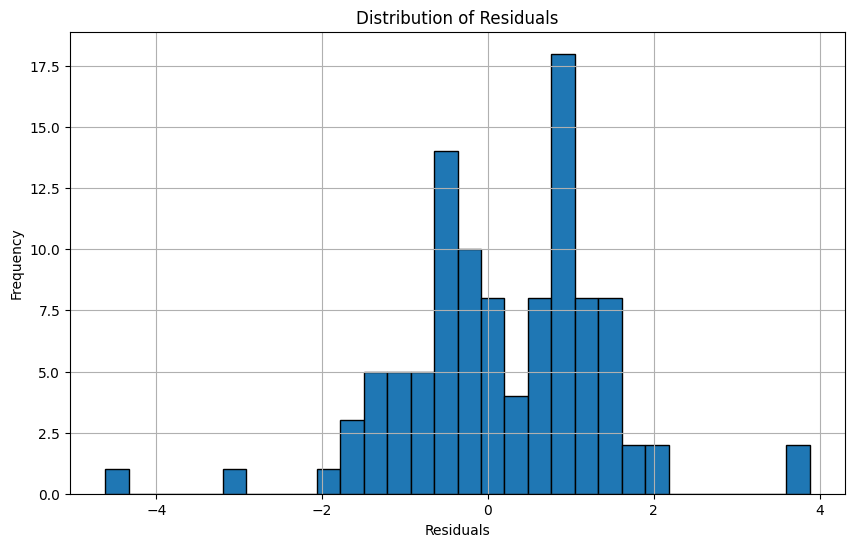

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
